## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [69]:
plt.rcParams['figure.figsize'] = (12,8)

In [63]:
import warnings
warnings.filterwarnings('ignore')

## Read Inp File

In [64]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 1 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 20 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    mutation_num_genes=1 # Type of the mutation operator.
    last_fitness = 0
    
    INP_FILE_PATH = r"../data/Real_Synthetic_Net.inp" 
    TEMP_DIR = "../temp/"
    PLOTS_DIR = "../plots"
    FUNCTION_INPUTS = None
    DESIRED_OUTPUT = None

In [159]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        self.node = node
        
        # Check if node is junction_name 
        wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        self.node_index = wn.junction_name_list.index(node)
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,wn.junction_name_list[self.node_index]]
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='Pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        emitter_value: the emitter coefficient value
        """

        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list, path:str, name:str):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
        

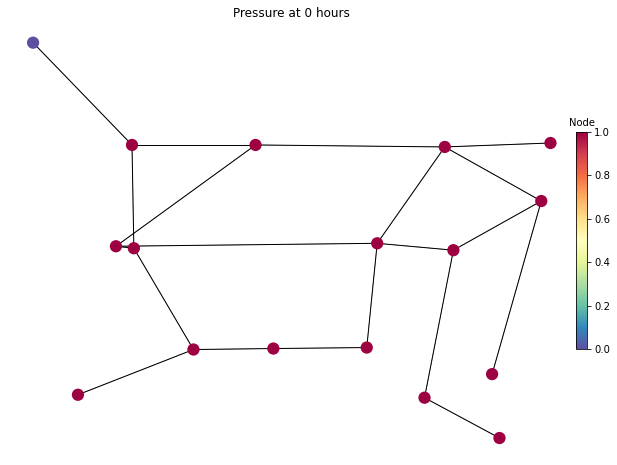

In [107]:
# Instantiate the pygad optimization class
config = Config()
water_model = WaterLeakModel(node='N6')
config.num_generations = 100

# Add leak and simulate
wn = wntr.network.WaterNetworkModel(config.INP_FILE_PATH)
node = wn.get_node('N6')
node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=.5)
water_model.simulate(wn, plot_graph=True)

config.FUNCTION_INPUTS = 0.5
config.DESIRED_OUTPUT = node.head - node.elevation

In [112]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(config.INP_FILE_PATH)
    results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0])) #change emitter coefficient

    pressure = results.node['pressure']
    output = pressure.loc[:,'N6']
    demands=results.node['demand']
    output_demand = demands.loc[:,'N6']

    fitness = 1.0 / (np.abs(output - config.DESIRED_OUTPUT) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]),'OUTPUT':list(output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(output_demand) [0]*1000)},ignore_index=True)
    data.to_csv(f"{config.TEMP_DIR}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(output,3))[0],'|===========|',list(round(fitness, 3))[0])
    print('================================='*2)

    return list(fitness)[0]

In [113]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{config.TEMP_DIR}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [114]:
# Instantiate the pygad optimization class
ga_instance = pygad.GA(num_generations=config.num_generations,
                       num_parents_mating=config.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=config.sol_per_pop,
                       num_genes=config.num_genes,
                       init_range_low=config.init_range_low,
                       init_range_high=config.init_range_high,
                       parent_selection_type=config.parent_selection_type,
                       keep_parents=config.keep_parents,
                       crossover_type=config.crossover_type,
                       mutation_type=config.mutation_type,
                       mutation_num_genes=config.mutation_num_genes,
                       callback_generation=callback_generation)

In [115]:
ga_instance.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 26.488 |===========| 19.01
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |===========| 34.087
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541 |===========| 2701.9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 |===========| 22.341
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |===========| 49.079
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |===========| 13.453
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |===========| 779.117
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 26.503

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.208 |===========| 26.427 |===========| 8.828
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.554 |===========| 75.708
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 26.535 |===========| 203.238
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 26.556 |===========| 63.206
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |===========| 14.909
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.376 |===========| 26.56 |===========| 51.331
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |===========| 40.727
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.58

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |===========| 14.909
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.376 |===========| 26.56 |===========| 51.331
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |===========| 40.727
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |===========| 20.417
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 26.569 |===========| 35.017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.948 |===========| 26.469 |===========| 14.049
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 26.538 |===========| 394.144
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |===========| 13.055
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 26.538 |===========| 367.216
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.919 |===========| 26.474 |===========| 15.01
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.585 |===========| 22.253
Generation = 2
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |===========| 212.274
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 26.506 |===========| 29.145
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.059 |===========| 26.451 |===========| 11.205
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |===========| 212.274
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 26.506 |===========| 29.145
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.059 |===========| 26.451 |===========| 11.205
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 26.509 |===========| 32.377
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |===========| 14.603
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 26.39 |===========| 6.633
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |===========| 14.352
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.605 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.342 |===========| 26.405 |===========| 7.392
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 26.511 |===========| 33.724
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 26.585 |===========| 22.191
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 26.431 |===========| 9.112
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |===========| 48.587
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |===========| 276.259
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.444 |===========| 10.431
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |===========| 276.259
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.444 |===========| 10.431
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |===========| 16.561
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 26.511 |===========| 33.741
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.297 |===========| 26.413 |===========| 7.823
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.083 |===========| 26.605 |===========| 15.424
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.123 |===========| 26.599 |===========| 17.041
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.083 |===========| 26.605 |===========| 15.424
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |===========| 14.701
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.572 |===========| 32.086
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |===========| 24.296
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.366 |===========| 26.401 |===========| 7.184
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.591 |===========| 19.891
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |===========| 59.041
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 26.46

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.591 |===========| 19.891
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |===========| 59.041
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 26.468 |===========| 13.876
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 26.595 |===========| 18.147
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 26.423 |===========| 8.489
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |===========| 16.411
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |===========| 431.613
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 26.48

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |===========| 431.613
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 26.488 |===========| 19.095
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 26.526 |===========| 69.609
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |===========| 67.645
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 26.61 |===========| 14.404
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |===========| 29.453
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |===========| 16.009
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.044 |===========| 26.45

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |===========| 42.28
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |===========| 13.576
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 26.455 |===========| 11.672
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 26.514 |===========| 38.433
Fitness = 4558.61688170001
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 26.546 |===========| 170.186
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 26.39 |===========| 6.631
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 26.544 |===========| 257.227
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 26.39 |===========| 6.631
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 26.544 |===========| 257.227
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 26.542 |===========| 704.65
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 26.611 |===========| 14.133
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 26.424 |===========| 8.586
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 26.54 |===========| 4558.617
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |===========| 28.497
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.567 |===========| 26.53

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 26.401 |===========| 7.19
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.273 |===========| 26.416 |===========| 8.07
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 26.466 |===========| 13.503
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |===========| 14.637
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.519 |===========| 45.953
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 26.59 |===========| 20.073
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |===========| 15.675
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.415 |===========| 26.393 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |===========| 15.675
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.415 |===========| 26.393 |===========| 6.792
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.196 |===========| 26.429 |===========| 8.976
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 26.49 |===========| 19.727
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |===========| 17.413
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 26.552 |===========| 86.905
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.742 |===========| 26.502 |===========| 26.138
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 26.544 |===========| 249.682
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.184 |===========| 26.431 |===========| 9.136
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |===========| 12.995
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.592 |===========| 19.181
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 26.411 |===========| 7.745
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.554 |===========| 75.989
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.606 |===========| 15.346
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.58

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.606 |===========| 15.346
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.587 |===========| 21.618
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |===========| 25.686
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |===========| 29.193
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.353 |===========| 26.403 |===========| 7.291
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 26.573 |===========| 30.449
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.14 |===========| 26.438 |===========| 9.777
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.343 |===========| 26.405 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |===========| 6.587
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.006 |===========| 26.46 |===========| 12.412
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 26.608 |===========| 14.863
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 26.506 |===========| 29.079
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.17 |===========| 26.592 |===========| 19.429
Generation = 8
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |===========| 26.462
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |===========| 50.733
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.052 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |===========| 26.462
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |===========| 50.733
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.052 |===========| 26.452 |===========| 11.368
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 26.513 |===========| 36.173
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.886 |===========| 26.479 |===========| 16.297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 26.533 |===========| 136.97
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 26.537 |===========| 332.045
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.78 |===========| 26.49

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |===========| 29.158
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.488 |===========| 26.381 |===========| 6.278
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |===========| 25.225
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.322 |===========| 26.408 |===========| 7.578
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |===========| 22.996
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.442 |===========| 26.389 |===========| 6.594
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |===========| 59.431
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.592 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |===========| 59.431
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.592 |===========| 19.539
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 26.602 |===========| 16.264
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 26.489 |===========| 19.614
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 26.478 |===========| 16.035
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |===========| 14.532
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |===========| 16.381
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 26.478 |===========| 16.035
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |===========| 14.532
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.096 |===========| 26.445 |===========| 10.511
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 26.583 |===========| 23.677
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 26.494 |===========| 21.642
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.39 |===========| 26.397 |===========| 6.985
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.603 |===========| 15.843
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.39 |===========| 26.397 |===========| 6.985
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.603 |===========| 15.843
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |===========| 21.974
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.581 |===========| 24.906
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.435 |===========| 26.39 |===========| 6.642
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 26.383 |===========| 6.35
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.35 |===========| 26.404 |===========| 7.325
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 26.459 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.61 |===========| 14.277
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.494 |===========| 21.345
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.063 |===========| 26.451 |===========| 11.137
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 26.47 |===========| 14.181
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 26.613 |===========| 13.699
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 26.404 |===========| 7.315
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.205 |===========| 26.427 |===========| 8.861
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 26.537 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.499 |===========| 26.379 |===========| 6.207
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 26.5 |===========| 24.772
Fitness = 4558.61688170001
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.602 |===========| 16.352
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 26.392 |===========| 6.718
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |===========| 21.056
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 26.559 |===========| 53.263
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.572 |===========| 32.109
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.572 |===========| 32.109
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.471 |===========| 26.545 |===========| 215.746
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.441 |===========| 26.55 |===========| 107.905
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |===========| 19.72
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |===========| 50.534
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.539 |===========| 26.534 |===========| 161.876
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.199 |===========| 26.428 |===========| 8.936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 26.46

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |===========| 12.915
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |===========| 28.43
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 26.53 |===========| 99.274
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |===========| 19.661
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |===========| 47.918
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.187 |===========| 26.589 |===========| 20.473
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |===========| 26.413 |===========| 7.856
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 26.441 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |===========| 47.918
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.187 |===========| 26.589 |===========| 20.473
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |===========| 26.413 |===========| 7.856
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 26.441 |===========| 10.039
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.424 |===========| 26.392 |===========| 6.723
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.527 |===========| 77.463
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.61 |===========| 14.259
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.498 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 26.43 |===========| 9.07
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501 |===========| 25.49
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |===========| 37.951
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 26.594 |===========| 18.522
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.245 |===========| 26.421 |===========| 8.375
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 26.515 |===========| 39.654
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 26.539 |===========| 541.447
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.245 |===========| 26.421 |===========| 8.375
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 26.515 |===========| 39.654
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 26.539 |===========| 541.447
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |===========| 24.264
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.543 |===========| 321.542
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |===========| 22.072
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |===========| 40.93
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 26.565 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |===========| 75.003
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 26.523 |===========| 56.458
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.395 |===========| 26.396 |===========| 6.943
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |===========| 15.069
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |===========| 201.501
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |===========| 39.193
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.262 |===========| 26.418 |===========| 8.183
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.46

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.463 |===========| 12.944
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |===========| 18.19
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |===========| 50.83
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |===========| 23.218
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |===========| 28.509
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |===========| 60.158
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 26.542 |===========| 512.617
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 26.449 |===========| 10.994
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 26.529 |===========| 85.426
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |===========| 13.97
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 26.498 |===========| 23.434
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 26.424 |===========| 8.563
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |===========| 22.9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |===========| 30.698
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |===========| 22.9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |===========| 30.698
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |===========| 7.34
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |===========| 28.898
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 26.541 |===========| 1419.709
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 26.602 |===========| 16.31
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |===========| 21.444
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 26.49 |===========| 19.988
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.44 |===========| 26.389 |===========| 6.607
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.591 |===========| 19.58
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |===========| 15.195
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |===========| 21.455
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |===========| 75.005
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |===========| 65.708
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 26.609 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |===========| 75.005
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |===========| 65.708
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 26.609 |===========| 14.487
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |===========| 21.356
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 26.556 |===========| 63.332
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |===========| 21.979
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 26.422 |===========| 8.465
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.225 |===========| 26.424 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |===========| 21.979
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 26.422 |===========| 8.465
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.225 |===========| 26.424 |===========| 8.616
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.425 |===========| 26.552 |===========| 85.027
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |===========| 22.439
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 26.463 |===========| 12.887
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 26.417 |===========| 8.105
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.854 |===========| 26.484 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |===========| 18.06
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.544 |===========| 245.444
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |===========| 18.108
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |===========| 15.089
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.193 |===========| 26.429 |===========| 9.015
Fitness = 4558.61688170001
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |===========| 21.156
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |===========| 41.367
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.193 |===========| 26.429 |===========| 9.015
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |===========| 21.156
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |===========| 41.367
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 26.555 |===========| 70.299
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |===========| 36.312
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |===========| 28.211
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |===========| 139.471
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.6

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |===========| 22.955
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 26.46 |===========| 12.475
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |===========| 156.126
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |===========| 1273.261
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 26.562 |===========| 45.915
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.34 |===========| 26.405 |===========| 7.413
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 26.593 |===========| 19.067
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.59

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 26.562 |===========| 45.915
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.34 |===========| 26.405 |===========| 7.413
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 26.593 |===========| 19.067
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |===========| 17.844
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |===========| 15.702
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |===========| 32.13
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 26.414 |===========| 7.921
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |===========| 14.228
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |===========| 28.953
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |===========| 51.164
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.331 |===========| 26.407 |===========| 7.496
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 26.618 |===========| 12.94
Generation = 19
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |===========| 18.641
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.884 |===========| 26.479 |===========| 16.378
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |===========| 18.641
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.884 |===========| 26.479 |===========| 16.378
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |===========| 14.699
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.465 |===========| 26.385 |===========| 6.432
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |===========| 7.265
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |===========| 24.396
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.143 |===========| 26.438 |===========| 9.728
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |===========| 25.989
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.767 |===========| 26.498 |===========| 23.699
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |===========| 40.701
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 26.429 |===========| 8.963
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.135 |===========| 26.439 |===========| 9.858
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 26.468 |===========| 13.795
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.281 |===========| 26.415 |===========| 7.987
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 26.468 |===========| 13.795
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.281 |===========| 26.415 |===========| 7.987
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |===========| 13.785
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.243 |===========| 26.421 |===========| 8.404
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 26.543 |===========| 382.342
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |===========| 21.013
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 26.416 |===========| 8.047
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.256 |===========| 26.419 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 26.585 |===========| 22.163
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |===========| 13.679
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 26.6 |===========| 16.756
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.185 |===========| 26.431 |===========| 9.128
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 26.585 |===========| 22.177
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 26.408 |===========| 7.584
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.366 |===========| 26.401 |===========| 7.181
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 26.594 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 26.594 |===========| 18.489
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |===========| 20.317
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |===========| 14.564
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.289 |===========| 26.414 |===========| 7.898
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02 |===========| 26.458 |===========| 12.078
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.335 |===========| 26.406 |===========| 7.454
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |===========| 13.824
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 26.527 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 26.527 |===========| 73.626
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 26.598 |===========| 17.215
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.673 |===========| 26.513 |===========| 36.639
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |===========| 38.845
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.555 |===========| 70.437
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |===========| 24.793
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 26.602 |===========| 16.25
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 26.395

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.388 |===========| 26.398 |===========| 7.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.959 |===========| 26.467 |===========| 13.698
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 26.468 |===========| 13.782
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |===========| 57.405
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.204 |===========| 26.428 |===========| 8.874
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.31 |===========| 26.41 |===========| 7.688
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.485 |===========| 26.382 |===========| 6.297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.31 |===========| 26.41 |===========| 7.688
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.485 |===========| 26.382 |===========| 6.297
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |===========| 27.957
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |===========| 16.164
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |===========| 125.035
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.262 |===========| 26.418 |===========| 8.187
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.403 |===========| 26.395 |===========| 6.882
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.593 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 26.596 |===========| 18.12
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.262 |===========| 26.418 |===========| 8.187
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.195 |===========| 26.429 |===========| 8.995
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |===========| 141.589
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 26.462 |===========| 12.724
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |===========| 10.303
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.284 |===========| 26.415 |===========| 7.949
Fitness = 4558.61688170001
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.284 |===========| 26.415 |===========| 7.949
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 26.514 |===========| 37.526
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 26.567 |===========| 37.179
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 26.521 |===========| 51.768
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |===========| 28.075
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 26.531 |===========| 109.737
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 26.585 |===========| 22.156
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 26.382 |===========| 6.327
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |===========| 13.642
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 26.449 |===========| 10.939
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 26.539 |===========| 651.346
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |===========| 10.111
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 26.608 |===========| 14.772
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |===========| 28.689
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 26.537 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |===========| 10.111
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 26.608 |===========| 14.772
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |===========| 28.689
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 26.537 |===========| 313.095
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.014 |===========| 26.458 |===========| 12.21
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 26.504 |===========| 27.589
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |===========| 303.558
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.143 |===========| 26.4

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.421 |===========| 26.392 |===========| 6.749
Generation = 25
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 26.46 |===========| 12.459
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |===========| 57.409
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |===========| 25.501
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 26.483 |===========| 17.373
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |===========| 19.229
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |===========| 12.374
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.666 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 26.483 |===========| 17.373
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |===========| 19.229
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |===========| 12.374
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.666 |===========| 26.514 |===========| 38.236
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |===========| 28.045
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |===========| 18.192
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.527 |===========| 77.541
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 26.43

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 26.536 |===========| 233.992
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |===========| 16.013
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.489 |===========| 26.381 |===========| 6.273
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.281 |===========| 26.415 |===========| 7.98
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |===========| 15.938
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 26.423 |===========| 8.495
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 26.563 |===========| 44.291
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.394 |===========| 26.397 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |===========| 15.938
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 26.423 |===========| 8.495
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 26.563 |===========| 44.291
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.394 |===========| 26.397 |===========| 6.952
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.063 |===========| 26.451 |===========| 11.132
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.302 |===========| 26.571 |===========| 32.226
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.44 |===========| 26.389 |===========| 6.603
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |===========| 18.628
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |===========| 20.088
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 26.475 |===========| 15.407
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 26.594 |===========| 18.552
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.122 |===========| 26.441 |===========| 10.069
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 26.518 |===========| 44.139
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.026 |===========| 26.456 |===========| 11.924
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 26.60

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 26.518 |===========| 44.139
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.026 |===========| 26.456 |===========| 11.924
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 26.608 |===========| 14.753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |===========| 18.259
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |===========| 21.651
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.827 |===========| 26.489 |===========| 19.293
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |===========| 13.955
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 26.4

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 26.481 |===========| 16.909
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.572 |===========| 26.529 |===========| 87.897
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |===========| 14.221
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 26.425 |===========| 8.655
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 26.508 |===========| 31.14
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.432 |===========| 26.39 |===========| 6.661
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 26.478 |===========| 16.036
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 26.572 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 26.478 |===========| 16.036
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 26.572 |===========| 31.452
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |===========| 14.228
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.374 |===========| 26.4 |===========| 7.116
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |===========| 18.263
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |===========| 34.858
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |===========| 17.992
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 26.474 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |===========| 34.858
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |===========| 17.992
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 26.474 |===========| 15.063
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |===========| 15.815
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |===========| 13.798
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.646 |===========| 26.517 |===========| 43.309
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |===========| 18.434
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 26.54

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |===========| 26.07
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 26.408 |===========| 7.582
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.92 |===========| 26.474 |===========| 14.961
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 26.561 |===========| 48.913
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 26.472 |===========| 14.733
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |===========| 21.484
Fitness = 4558.61688170001
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |===========| 34.83
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |===========| 34.83
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 26.57 |===========| 33.445
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.625 |===========| 26.521 |===========| 50.694
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.954 |===========| 26.468 |===========| 13.849
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.26 |===========| 26.419 |===========| 8.211
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.256 |===========| 26.419 |===========| 8.249
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |===========| 67.317
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 26.428 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 26.57 |===========| 33.458
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 26.593 |===========| 19.045
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |===========| 60.613
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.35 |===========| 26.404 |===========| 7.325
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |===========| 13.37
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 26.541 |===========| 894.966
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 26.531 |===========| 103.873
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |===========| 13.37
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 26.541 |===========| 894.966
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 26.531 |===========| 103.873
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541 |===========| 3532.2
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.875 |===========| 26.481 |===========| 16.803
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.569 |===========| 35.512
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.251 |===========| 26.42 |===========| 8.305
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 26.611

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |===========| 14.803
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |===========| 21.102
Generation = 31
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |===========| 7.338
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 26.616 |===========| 13.296
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 26.606 |===========| 15.252
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 26.518 |===========| 44.204
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 26.591 |===========| 19.861
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 26.606 |===========| 15.252
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 26.518 |===========| 44.204
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 26.591 |===========| 19.861
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |===========| 14.371
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 26.45 |===========| 11.1
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |===========| 15.46
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.569 |===========| 35.486
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.416 |===========| 26.393 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |===========| 71.772
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 26.392 |===========| 6.729
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.495 |===========| 26.38 |===========| 6.23
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |===========| 15.163
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 26.489 |===========| 19.558
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |===========| 19.329
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |===========| 24.349
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.37 |===========| 26.4 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |===========| 19.329
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |===========| 24.349
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.37 |===========| 26.4 |===========| 7.147
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 26.475 |===========| 15.296
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.381 |===========| 6.256
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.591 |===========| 19.907
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |===========| 26.817
Change = 2044.9303038676035
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |===========| 26.817
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |===========| 63.814
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.581 |===========| 24.896
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.233 |===========| 26.423 |===========| 8.519
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.989 |===========| 26.463 |===========| 12.847
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |===========| 22.547
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 26.544 |===========| 262.27
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 26.508 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 26.544 |===========| 262.27
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 26.508 |===========| 30.949
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 26.535 |===========| 177.538
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 26.466 |===========| 13.362
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 26.549 |===========| 111.039
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 26.542 |===========| 540.977
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |===========| 33.889
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 26.542 |===========| 540.977
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |===========| 33.889
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.605 |===========| 15.503
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |===========| 28.249
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.589 |===========| 20.373
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 26.583 |===========| 23.5
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.5 |===========| 26.54 |===========| 23562.04
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.206 |===========| 26.427 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |===========| 11.155
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |===========| 20.079
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |===========| 15.664
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.467 |===========| 26.385 |===========| 6.418
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |===========| 14.377
Fitness = 23562.03998371808
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 26.534 |===========| 158.377
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |===========| 20.239
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 26.534 |===========| 158.377
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |===========| 20.239
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |===========| 114.663
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.744 |===========| 26.502 |===========| 25.87
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.605 |===========| 15.485
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 26.408 |===========| 7.528
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 26.424 |===========| 8.592
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.492 |===========| 26.38 |===========| 6.25
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.848 |===========| 26.485 |===========| 18.12
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |===========| 22.567
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |===========| 463.108
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.097 |===========| 26.445 |===========| 10.491
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 26.458 |===========| 12.157
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 26.447 |===========| 10.726
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 26.584 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 26.458 |===========| 12.157
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 26.447 |===========| 10.726
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 26.584 |===========| 23.045
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.584 |===========| 22.66
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 26.468 |===========| 13.789
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |===========| 26.826
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |===========| 16.462
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 26.488 |===========| 19.234
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.134 |===========| 26.439 |===========| 9.865
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |===========| 67.26
Generation = 36
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 26.47 |===========| 14.146
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |===========| 21.983
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.395 |===========| 26.396 |===========| 6.943
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 26.527 |===========| 72.9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |===========| 21.983
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.395 |===========| 26.396 |===========| 6.943
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 26.527 |===========| 72.9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 26.384 |===========| 6.414
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |===========| 34.231
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.123 |===========| 26.599 |===========| 17.054
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |===========| 16.412
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |===========| 26.413 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.603 |===========| 26.524 |===========| 61.423
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 26.567 |===========| 37.265
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 26.488 |===========| 19.077
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.583 |===========| 26.527 |===========| 76.074
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.764 |===========| 26.499 |===========| 23.917
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |===========| 30.054
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.207 |===========| 26.427 |===========| 8.833
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.50

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.764 |===========| 26.499 |===========| 23.917
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |===========| 30.054
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.207 |===========| 26.427 |===========| 8.833
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.509 |===========| 32.279
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.144 |===========| 26.437 |===========| 9.706
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 26.569 |===========| 35.194
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |===========| 35.729
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 26.569 |===========| 35.194
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |===========| 35.729
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |===========| 36.556
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |===========| 18.753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |===========| 130.15
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.949 |===========| 26.469 |===========| 13.999
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.256 |===========| 26.419 |===========| 8.249
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 26.52

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.949 |===========| 26.469 |===========| 13.999
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.256 |===========| 26.419 |===========| 8.249
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 26.524 |===========| 59.42
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 26.567 |===========| 37.126
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 26.558 |===========| 56.075
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |===========| 48.206
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.39 |===========| 26.397 |===========| 6.984
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.964 |===========| 26.467 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |===========| 48.206
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.39 |===========| 26.397 |===========| 6.984
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.964 |===========| 26.467 |===========| 13.557
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |===========| 13.775
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.614 |===========| 13.669
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |===========| 46.623
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |===========| 59.127
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 26.561 |===========| 47.69
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 26.564 |===========| 42.09
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 26.48 |===========| 16.548
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.388 |===========| 26.398 |===========| 7.001
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 26.422 |===========| 8.465
Fitness = 23562.03998371808
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.239 |===========| 26.422 |===========| 8.443
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 26.565 |===========| 40.187
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.239 |===========| 26.422 |===========| 8.443
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 26.565 |===========| 40.187
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |===========| 102.533
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |===========| 8.481
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.272 |===========| 26.417 |===========| 8.076
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.088 |===========| 26.447 |===========| 10.657
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 26.52 |===========| 48.243
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.381 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.376 |===========| 26.399 |===========| 7.099
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 26.552 |===========| 87.878
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 26.421 |===========| 8.344
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 26.474 |===========| 15.121
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 26.593 |===========| 18.888
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |===========| 209.449
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |===========| 21.282
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.368 |===========| 26.401 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |===========| 209.449
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |===========| 21.282
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.368 |===========| 26.401 |===========| 7.164
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |===========| 22.849
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |===========| 25.743
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.26 |===========| 26.418 |===========| 8.204
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.143 |===========| 26.438 |===========| 9.731
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.414 |===========| 26.393 |===========| 6.802
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.422 |===========| 26.392 |===========| 6.736
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 26.591 |===========| 19.856
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 26.618 |===========| 12.935
Generation = 41
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.561 |===========| 47.342
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |===========| 16.86
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |===========| 18.281
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.017 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |===========| 16.86
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |===========| 18.281
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.017 |===========| 26.458 |===========| 12.141
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 26.501 |===========| 25.665
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 26.537 |===========| 261.617
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.198 |===========| 26.429 |===========| 8.944
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |===========| 17.533
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 26.486 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 26.405 |===========| 7.367
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 26.47 |===========| 14.175
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |===========| 21.75
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.151 |===========| 26.436 |===========| 9.606
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 26.616 |===========| 13.152
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.387 |===========| 26.398 |===========| 7.008
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 26.547 |===========| 146.272
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 26.616 |===========| 13.152
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.387 |===========| 26.398 |===========| 7.008
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 26.547 |===========| 146.272
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |===========| 59.187
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.471 |===========| 26.545 |===========| 219.884
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.045 |===========| 26.453 |===========| 11.497
Change = 1707.9237173779475
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |===========| 41.295
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.471 |===========| 26.545 |===========| 219.884
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.045 |===========| 26.453 |===========| 11.497
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.364 |===========| 26.402 |===========| 7.203
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.733 |===========| 26.504 |===========| 27.157
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |===========| 41.176
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 26.511 |===========| 33.677
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |===========| 16.939
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 26.4

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |===========| 41.176
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 26.511 |===========| 33.677
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |===========| 16.939
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 26.411 |===========| 7.755
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 26.615 |===========| 13.459
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 26.552 |===========| 88.3
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 26.513 |===========| 36.949
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 26.552 |===========| 88.3
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 26.513 |===========| 36.949
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |===========| 14.588
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.887 |===========| 26.479 |===========| 16.25
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 26.522 |===========| 54.076
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 26.419 |===========| 8.239
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 26.431 |===========| 9.114
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 26.54 |===========| 1378.69
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.205 |===========| 26.428 |===========| 8.865
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 26.55 |===========| 103.898
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 26.554 |===========| 73.856
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.559 |===========| 52.34
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.431 |===========| 26.391 |===========| 6.673
Fitness = 25269.96370563335
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 26.555 |===========| 69.726
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.431 |===========| 26.391 |===========| 6.673
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 26.555 |===========| 69.726
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |===========| 29.244
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |===========| 33.91
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 26.537 |===========| 306.58
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 26.574 |===========| 29.667
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 26.574 |===========| 29.849
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.214 |===========| 26.426 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |===========| 19.758
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |===========| 14.933
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |===========| 477.834
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 26.571 |===========| 33.06
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |===========| 27.471
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |===========| 51.971
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.381 |===========| 26.399 |===========| 7.059
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.492 |===========| 26.38 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |===========| 27.471
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |===========| 51.971
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.381 |===========| 26.399 |===========| 7.059
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.492 |===========| 26.38 |===========| 6.254
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.481 |===========| 26.382 |===========| 6.323
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.066 |===========| 26.45 |===========| 11.08
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |===========| 26.81
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 26.488 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |===========| 21.143
Generation = 46
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 26.531 |===========| 104.857
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.442 |===========| 26.389 |===========| 6.589
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.361 |===========| 26.402 |===========| 7.223
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |===========| 14.923
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.398 |===========| 26.396 |===========| 6.921
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |===========| 35.237
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |===========| 14.923
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.398 |===========| 26.396 |===========| 6.921
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |===========| 35.237
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===========| 26.482 |===========| 17.178
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 26.562 |===========| 46.384
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.569 |===========| 35.525
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |===========| 32.777
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.233 |===========| 26.423

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 26.56 |===========| 50.155
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.024 |===========| 26.457 |===========| 11.97
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.498 |===========| 23.767
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |===========| 41.582
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.042 |===========| 26.454 |===========| 11.562
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |===========| 291.505
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |===========| 356.818
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 26.53

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.042 |===========| 26.454 |===========| 11.562
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |===========| 291.505
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |===========| 356.818
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 26.532 |===========| 127.191
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.525 |===========| 26.536 |===========| 259.14
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |===========| 34.92
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.445 |===========| 10.446
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.525 |===========| 26.536 |===========| 259.14
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |===========| 34.92
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.445 |===========| 10.446
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 26.537 |===========| 287.388
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |===========| 9.46
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 26.595 |===========| 18.316
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 26.604 |===========| 15.643
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 26.595 |===========| 18.316
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 26.604 |===========| 15.643
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |===========| 28.644
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |===========| 13.21
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 26.593 |===========| 18.872
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.152 |===========| 26.436 |===========| 9.587
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 26.463 |===========| 12.894
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |===========| 24.509
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |===========| 13.748
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |===========| 58.803
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 26.551 |===========| 96.617
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 26.382 |===========| 6.33
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |===========| 13.236
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 26.459 |===========| 12.334
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 26.383 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.38 |===========| 6.255
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.175 |===========| 26.432 |===========| 9.26
Fitness = 25269.96370563335
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |===========| 37.63
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.384 |===========| 26.398 |===========| 7.038
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 26.476 |===========| 15.475
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 26.401 |===========| 7.192
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |===========| 49.202
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 26.401 |===========| 7.192
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |===========| 49.202
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.026 |===========| 26.456 |===========| 11.925
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |===========| 59.714
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 26.544 |===========| 279.198
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |===========| 41.533
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 26.565 |===========| 40.332
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.47

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.047 |===========| 26.453 |===========| 11.468
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |===========| 16.611
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.61 |===========| 14.264
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |===========| 12.582
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 26.547 |===========| 150.889
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |===========| 13.672
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 26.465 |===========| 13.252
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.57

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 26.547 |===========| 150.889
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |===========| 13.672
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 26.465 |===========| 13.252
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |===========| 31.025
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |===========| 57.879
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |===========| 21.403
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 26.613 |===========| 13.698
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.848 |===========| 26.48

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.978 |===========| 26.464 |===========| 13.139
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |===========| 29.039
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 26.563 |===========| 43.402
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 26.405 |===========| 7.404
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.231 |===========| 26.582 |===========| 23.809
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |===========| 163.4
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.078 |===========| 26.448 |===========| 10.845
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |===========| 20.294
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.421 |===========| 8.357
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |===========| 21.3
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.242 |===========| 26.422 |===========| 8.414
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 26.465 |===========| 13.199
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |===========| 22.622
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 26.516 |===========| 40.459
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.445 |===========| 26.388 |===========| 6.567
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 26.462 |===========| 12.785
Generation = 52
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 26.392 |===========| 6.73
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |===========| 55.249
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |===========| 15.47
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 26.507 |===========| 30.106
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |===========| 8.576
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 26.507 |===========| 30.106
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |===========| 8.576
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.519 |===========| 45.907
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.602 |===========| 16.346
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |===========| 29.53
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |===========| 101.467
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |===========| 17.573
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 26.583 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |===========| 25.162
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |===========| 13.849
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |===========| 18.242
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 26.527 |===========| 74.105
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.588 |===========| 21.055
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.445 |===========| 26.388 |===========| 6.571
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 26.502 |===========| 26.225
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 26.409

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 26.502 |===========| 26.225
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 26.409 |===========| 7.641
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |===========| 24.251
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |===========| 76.742
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |===========| 17.983
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |===========| 15.679
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.28 |===========| 26.415 |===========| 7.989
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 26.583 |===========| 23.284
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 26.468 |===========| 13.81
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |===========| 28.901
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 26.487 |===========| 18.802
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.261 |===========| 26.418 |===========| 8.193
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |===========| 6.462
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |===========| 28.572
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.261 |===========| 26.418 |===========| 8.193
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |===========| 6.462
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |===========| 28.572
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |===========| 42.518
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |===========| 23.113
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.509 |===========| 32.212
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |===========| 487.545
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 26.507 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.509 |===========| 32.212
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |===========| 487.545
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 26.507 |===========| 29.996
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.149 |===========| 26.437 |===========| 9.63
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |===========| 780.548
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 26.446 |===========| 10.572
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |===========| 18.788
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.109 |===========| 26.4

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 26.602 |===========| 16.097
Fitness = 25269.96370563335
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.109 |===========| 26.443 |===========| 10.287
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.083 |===========| 26.605 |===========| 15.431
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 26.55 |===========| 109.183
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |===========| 34.078
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.047 |===========| 26.453 |===========| 11.455
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |===========| 99.847
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |===========| 99.847
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 26.466 |===========| 13.381
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.604 |===========| 15.818
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |===========| 13.74
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |===========| 13.675
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |===========| 13.743
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.38 |===========| 26.399 |===========| 7.066
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.543 |==

======| 0.201 |===========| 26.587 |===========| 21.407
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |===========| 15.3
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.174 |===========| 26.433 |===========| 9.28
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |===========| 13.856
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.771 |===========| 26.497 |===========| 23.319
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.144 |===========| 26.437 |===========| 9.71
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 26.606 |===========| 15.265
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |===========| 85.932
=====|SOLUTION|===========|OUTPUT|==================|FI

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |===========| 85.932
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |===========| 37.663
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 26.602 |===========| 16.11
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.389 |===========| 26.397 |===========| 6.997
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 26.492 |===========| 20.557
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |===========| 493.94
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |===========| 14.701
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.562

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.563 |===========| 26.53 |===========| 100.807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |===========| 27.779
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 26.459 |===========| 12.292
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.421 |===========| 8.356
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |===========| 7.271
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 26.616 |===========| 13.249
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |===========| 199.745
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |===========| 199.745
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |===========| 15.54
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 26.546 |===========| 170.303
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.103 |===========| 26.444 |===========| 10.379
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |===========| 9.453
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |===========| 175.206
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |===========| 23.864
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 26.52 |===========| 49.33
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.495 |===========| 26.38 |===========| 6.235
Generation = 58
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 26.473 |===========| 14.862
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.793 |===========| 26.494 |===========| 21.561
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 26.599 |===========| 17.108
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |===========| 100.195
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |===========| 36.638
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |===========| 100.195
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |===========| 36.638
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |===========| 132.778
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 26.599 |===========| 17.122
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 26.612 |===========| 13.922
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.077 |===========| 26.448 |===========| 10.855
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 26.5 |===========| 24.83
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |===========| 103.429
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 26.498 |===========| 23.461
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.214 |===========| 26.426 |===========| 8.751
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |===========| 15.369
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.358 |===========| 26.403 |===========| 7.256
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 26.455 |===========| 11.7
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |===========| 26.413 |===========| 7.862
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 26.463 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 26.455 |===========| 11.7
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |===========| 26.413 |===========| 7.862
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 26.463 |===========| 12.919
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 26.447 |===========| 10.726
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.797 |===========| 26.493 |===========| 21.219
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.368 |===========| 26.401 |===========| 7.165
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |===========| 607.55
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.368 |===========| 26.401 |===========| 7.165
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 26.455 |===========| 11.707
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |===========| 13.234
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |===========| 21.857
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |===========| 205.632
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 26.506 |===========| 29.199
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 26.527 |===========| 73.859
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.4

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 26.506 |===========| 29.199
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 26.527 |===========| 73.859
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.421 |===========| 8.349
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |===========| 25.744
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |===========| 22.861
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |===========| 47.248
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 26.481 |===========| 16.987
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |===========| 47.248
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 26.481 |===========| 16.987
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538 |===========| 507.87
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |===========| 41.58
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |===========| 24.077
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |===========| 12.92
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |===========| 18.622
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 26.452

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 26.493 |===========| 21.18
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.217 |===========| 26.426 |===========| 8.707
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 26.486 |===========| 18.545
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |===========| 6.441
Fitness = 25269.96370563335
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |===========| 25.226
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.459 |===========| 26.386 |===========| 6.47
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.604 |===========| 15.822
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.604 |===========| 15.822
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |===========| 9.489
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |===========| 37.66
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 26.611 |===========| 14.151
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.071 |===========| 26.449 |===========| 10.967
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.786 |===========| 26.495 |===========| 22.044
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |===========| 236.572
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.211 |===========| 26.427

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.283 |===========| 26.415 |===========| 7.963
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 26.6 |===========| 16.79
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.132 |===========| 26.439 |===========| 9.906
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 26.395 |===========| 6.893
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |===========| 15.724
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 26.468 |===========| 13.726
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |===========| 106.116
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 26.533 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 26.533 |===========| 138.708
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 26.596 |===========| 17.918
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.444 |===========| 26.388 |===========| 6.578
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 26.428 |===========| 8.886
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.029 |===========| 26.456 |===========| 11.87
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |===========| 17.54
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 26.59 |===========| 20.227
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.771 |===========| 26.497 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |===========| 142.594
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 26.481 |===========| 16.974
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.364 |===========| 26.401 |===========| 7.197
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |===========| 6.587
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |===========| 8.484
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.375 |===========| 26.4 |===========| 7.104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.174 |===========| 26.433 |===========| 9.272
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.174 |===========| 26.433 |===========| 9.272
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |===========| 41.304
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 26.561 |===========| 49.255
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |===========| 100.448
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.266 |===========| 26.418 |===========| 8.146
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.421 |===========| 8.347
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |===========| 15.828
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.136 |===========| 26.439 |===========| 9.837
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 26.526 |===========| 72.02
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |===========| 46.535
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |===========| 33.87
Generation = 64
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |===========| 21.294
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |===========| 95.693
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 26.53 |===========| 99.024
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 26.53 |===========| 99.024
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 26.597 |===========| 17.698
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 26.512 |===========| 35.419
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 26.533 |===========| 127.58
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 26.532 |===========| 121.312
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |===========| 13.762
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.376 |===========| 26.56 |===========| 51.598
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 26.516

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 26.404 |===========| 7.314
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 26.571 |===========| 32.955
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 26.537 |===========| 264.351
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |===========| 15.319
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.264 |===========| 26.418 |===========| 8.167
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.291 |===========| 26.413 |===========| 7.875
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.101 |===========| 26.444 |===========| 10.423
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.438 |===========| 26.389 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.291 |===========| 26.413 |===========| 7.875
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.101 |===========| 26.444 |===========| 10.423
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.438 |===========| 26.389 |===========| 6.619
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.43 |===========| 26.391 |===========| 6.68
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |===========| 16.961
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.078 |===========| 26.448 |===========| 10.847
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |===========| 30.699
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |===========| 30.699
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |===========| 14.652
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 26.465 |===========| 13.26
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.589 |===========| 20.365
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.59 |===========| 20.326
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 26.411 |===========| 7.707
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |===========| 130.338
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.158 |===========| 26.435

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |===========| 130.338
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.158 |===========| 26.435 |===========| 9.51
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 26.519 |===========| 46.132
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.396 |===========| 26.396 |===========| 6.94
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |===========| 22.398
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.589 |===========| 20.364
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |===========| 8.893
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.573 |===========| 30.197
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.352 |===========| 26.403 |===========| 7.306
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 26.561 |===========| 48.954
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 26.502 |===========| 26.027
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |===========| 13.484
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 26.45 |===========| 11.101
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.024 |===========| 26.457 |===========| 11.979
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 26.556 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |===========| 128.733
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |===========| 48.801
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.496 |===========| 22.777
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 26.598 |===========| 17.2
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.459 |===========| 26.386 |===========| 6.475
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |===========| 30.712
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |===========| 12.998
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.964 |===========| 26.466 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |===========| 30.712
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |===========| 12.998
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.964 |===========| 26.466 |===========| 13.539
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 26.46 |===========| 12.49
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 26.482 |===========| 17.093
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |===========| 13.626
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |===========| 18.304
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.387 |===========| 26.558 |===========| 56.586
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |===========| 30.971
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 26.449 |===========| 10.931
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 26.401 |===========| 7.196
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 26.46 |===========| 12.454
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |===========| 6.588
Fitness = 25269.96370563335
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.034 |===========| 26.455 |===========| 11.747
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 26.46 |===========| 12.454
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |===========| 6.588
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.034 |===========| 26.455 |===========| 11.747
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.185 |===========| 26.431 |===========| 9.122
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |===========| 13.493
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |===========| 21.526
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |===========| 28.976
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |===========| 12.919
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 26.436 |===========| 9.55
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |===========| 210.144
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 26.415 |===========| 7.998
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 26.506 |===========| 29.178
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.442 |===========| 10.119
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 26.458 |===========| 12.186
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.336 |===========| 26.406 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.442 |===========| 10.119
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 26.458 |===========| 12.186
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.336 |===========| 26.406 |===========| 7.447
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.083 |===========| 26.447 |===========| 10.749
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.076 |===========| 26.448 |===========| 10.87
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 26.616 |===========| 13.148
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.382 |===========| 26.399 |===========| 7.05
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 26.459 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 26.444 |===========| 10.338
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538 |===========| 495.36
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.978 |===========| 26.464 |===========| 13.152
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 26.384 |===========| 6.412
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |===========| 148.339
Generation = 70
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |===========| 413.891
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.694 |===========| 26.51 |===========| 32.653
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |===========| 148.339
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |===========| 413.891
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.694 |===========| 26.51 |===========| 32.653
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |===========| 22.576
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.42 |===========| 26.392 |===========| 6.754
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 26.494 |===========| 21.701
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |===========| 233.462
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.152 |===========| 26.436 |===========| 9.6
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |===========| 9.487
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.878 |===========| 26.48 |===========| 16.64
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |===========| 1895.608
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 26.417 |===========| 8.112
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |===========| 14.321
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.118 |===========| 26.442 |===========| 10.126
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.146 |===========| 26.437 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.146 |===========| 26.437 |===========| 9.682
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |===========| 116.072
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.81 |===========| 26.491 |===========| 20.321
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 26.6 |===========| 16.665
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |===========| 22.382
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |===========| 13.492
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 26.481 |===========| 16.718
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.49 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |===========| 14.658
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 26.555 |===========| 66.389
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.591 |===========| 19.901
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 26.491 |===========| 20.432
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 26.583 |===========| 23.31
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |===========| 20.29
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.34 |===========| 26.405 |===========| 7.414
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 26.408 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 26.583 |===========| 23.31
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |===========| 20.29
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.34 |===========| 26.405 |===========| 7.414
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 26.408 |===========| 7.568
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |===========| 18.295
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |===========| 18.442
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |===========| 24.74
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |===========| 114.518
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.265 |===========| 26.418 |===========| 8.158
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 26.563 |===========| 43.469
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |===========| 20.851
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 26.593 |===========| 18.878
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |===========| 11.41
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.885 |===========| 26.479 |===========| 16.374
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 26.537 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 26.514 |===========| 37.257
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 26.543 |===========| 335.49
Fitness = 25269.96370563335
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.885 |===========| 26.479 |===========| 16.374
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 26.537 |===========| 293.044
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 26.397 |===========| 6.982
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |===========| 16.544
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |===========| 28.396
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.827 |===========| 26.488 |===========| 19.275
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.053 |===========| 26.452 |===========| 11.341
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.253 |===========| 26.42 |===========| 8.288
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 26.561 |===========| 49.048
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.997 |===========| 26.461 |===========| 12.643
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |===========| 11.146
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |===========| 14.47
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.043 |===========| 26.454 |===========| 11.544
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 26.457 |===========| 12.052
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.179 |===========| 26.432 |===========| 9.207
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 26.503 |===========| 26.687
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.326 |===========| 26.408 |===========| 7.541
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.101 |===========| 26.444 |===========| 10.415
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |===========| 12.383
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.291 |===========| 26.413 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.291 |===========| 26.413 |===========| 7.879
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.035 |===========| 26.455 |===========| 11.73
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |===========| 16.948
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.405 |===========| 26.395 |===========| 6.87
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |===========| 13.577
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |===========| 20.445
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |===========| 153.432
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 26.563 |===========| 43.291
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.823 |===========| 26.489 |===========| 19.506
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 26.525 |===========| 66.135
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 26.473 |===========| 14.874
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |===========| 15.918
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 26.606 |===========| 15.263
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |===========| 19.736
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |===========| 15.918
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 26.606 |===========| 15.263
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |===========| 19.736
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 26.537 |===========| 342.839
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |===========| 32.786
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 26.555 |===========| 69.298
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |===========| 15.605
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.322 |===========| 26.408 |===========| 7.573
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |===========| 30.588
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.421 |===========| 26.392 |===========| 6.748
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.592 |===========| 19.54
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |===========| 103.278
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.012 |===========| 26.459 |===========| 12.258
Generation = 76
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |===========| 21.444
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.012 |===========| 26.459 |===========| 12.258
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |===========| 21.444
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |===========| 34.958
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |===========| 28.423
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 26.6 |===========| 16.789
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 26.55 |===========| 105.035
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |===========| 17.887
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.244 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 26.597 |===========| 17.506
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |===========| 32.167
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.346 |===========| 26.404 |===========| 7.359
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 26.462 |===========| 12.781
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |===========| 102.295
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |===========| 24.969
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===========| 26.482 |===========| 17.179
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |===========| 102.295
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |===========| 24.969
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===========| 26.482 |===========| 17.179
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |===========| 29.981
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |===========| 20.194
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.492 |===========| 26.38 |===========| 6.252
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 26.533 |===========| 142.978
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 |===========| 135.448
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |===========| 91.063
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 26.603 |===========| 16.055
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |===========| 13.327
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 26.49 |===========| 19.696
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 26.485 |===========| 18.039
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.475 |===========| 26.383 |===========| 6.362
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 26.509 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 26.485 |===========| 18.039
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.475 |===========| 26.383 |===========| 6.362
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 26.509 |===========| 31.921
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 26.53 |===========| 98.035
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |===========| 14.336
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.605 |===========| 15.482
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |===========| 389.651
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.605 |===========| 15.482
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |===========| 389.651
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |===========| 12.918
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |===========| 35.383
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.295 |===========| 26.413 |===========| 7.842
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |===========| 13.824
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |===========| 30.93
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.57

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |===========| 29.154
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 26.593 |===========| 19.017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |===========| 29.049
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.411 |===========| 26.394 |===========| 6.822
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |===========| 76.339
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |===========| 49.031
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |===========| 208.635
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 26.559 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 26.559 |===========| 54.004
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 26.472 |===========| 14.731
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.196 |===========| 26.429 |===========| 8.978
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.539 |===========| 26.534 |===========| 164.328
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 26.469 |===========| 14.075
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.138 |===========| 26.438 |===========| 9.81
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 26.568 |===========| 35.616
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.572 |===========| 26.529

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |===========| 17.184
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 26.612 |===========| 13.876
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.301 |===========| 26.412 |===========| 7.782
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.005 |===========| 26.46 |===========| 12.424
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.231 |===========| 26.582 |===========| 23.813
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 26.507 |===========| 29.876
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |===========| 177.227
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |===========| 177.227
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |===========| 17.357
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.115 |===========| 26.442 |===========| 10.176
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 26.476 |===========| 15.598
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.771 |===========| 26.497 |===========| 23.326
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 26.525 |===========| 67.008
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |===========| 67.49
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 26.60

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 26.49 |===========| 19.848
Generation = 81
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 26.459 |===========| 12.313
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.457 |===========| 26.386 |===========| 6.483
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |===========| 24.362
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 26.508 |===========| 30.506
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.134 |===========| 26.439 |===========| 9.872
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 26.46 |===========| 12.459
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 26.46 |===========| 12.459
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 26.577 |===========| 27.13
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 26.517 |===========| 42.209
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.135 |===========| 26.439 |===========| 9.856
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |===========| 57.617
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.355 |===========| 26.403 |===========| 7.276
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |===========| 77.016
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.691 |===========| 26.51 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.172 |===========| 26.433 |===========| 9.306
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 26.578 |===========| 26.565
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 26.542 |===========| 687.203
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 26.503 |===========| 26.533
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.61 |===========| 14.272
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |===========| 14.645
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 26.465 |===========| 13.19
Generation = 82
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |===========| 14.645
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 26.465 |===========| 13.19
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |===========| 7.468
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |===========| 22.106
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |===========| 211.835
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.374 |===========| 26.4 |===========| 7.116
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 26.465 |===========| 13.327
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.763 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 26.552 |===========| 89.711
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 26.608 |===========| 14.754
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 |===========| 134.373
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 26.542 |===========| 682.073
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.026 |===========| 26.457 |===========| 11.929
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.22 |===========| 26.425 |===========| 8.672
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |===========| 26.479 |===========| 16.175
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6

======| 1.22 |===========| 26.425 |===========| 8.672
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |===========| 26.479 |===========| 16.175
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |===========| 16.872
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 26.58 |===========| 25.023
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |===========| 25.688
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |===========| 6.45
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 26.544 |===========| 252.983
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 26.577 |===========| 27.143
=====|SOLUTION|===========|OUTPUT|==================|F

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |===========| 6.45
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 26.544 |===========| 252.983
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 26.577 |===========| 27.143
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |===========| 13.032
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 26.535 |===========| 173.979
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 26.419 |===========| 8.244
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |===========| 833.142
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |===========| 833.142
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 26.573 |===========| 30.837
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.435 |===========| 26.551 |===========| 97.808
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.142 |===========| 26.438 |===========| 9.74
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.253 |===========| 26.42 |===========| 8.287
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |===========| 93.517
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 26.533 |===========| 138.033
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.102 |===========| 26.444

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |===========| 18.229
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 26.518 |===========| 43.879
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |===========| 17.831
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |===========| 20.87
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.136 |===========| 26.439 |===========| 9.833
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.853 |===========| 26.484 |===========| 17.868
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 26.464 |===========| 13.172
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |===========| 67.102
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |===========| 41.839
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 26.571 |===========| 32.696
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 26.604 |===========| 15.659
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |===========| 39.846
Fitness = 25269.96370563335
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.372 |===========| 26.4 |===========| 7.135
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.605 |===========| 15.352
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.372 |===========| 26.4 |===========| 7.135
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.605 |===========| 15.352
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 26.611 |===========| 14.107
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 26.497 |===========| 23.104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 26.536 |===========| 235.571
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 26.497 |===========| 23.108
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |===========| 390.291
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.57

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.764 |===========| 26.499 |===========| 23.934
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 26.572 |===========| 32.007
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |===========| 26.104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.474 |===========| 26.383 |===========| 6.369
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 26.541 |===========| 1782.498
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |===========| 72.475
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.276 |===========| 26.416 |===========| 8.031
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |===========| 72.475
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.276 |===========| 26.416 |===========| 8.031
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |===========| 13.818
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 26.486 |===========| 18.526
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.442 |===========| 26.389 |===========| 6.591
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |===========| 33.241
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |===========| 19.199
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 26.606 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 26.525 |===========| 66.259
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.195 |===========| 26.429 |===========| 8.988
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |===========| 59.623
Generation = 87
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |===========| 63.852
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |===========| 16.475
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |===========| 18.747
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |===========| 9.488
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 26.459 |===========| 12.361
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.445 |===========| 10.445
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |===========| 6.463
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |===========| 14.535
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |===========| 153.939
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.305 |===========| 26.411 |===========| 7.737
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.114 |===========| 26.442 |===========| 10.2
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.593 |===========| 26.526 |===========| 68.344
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.555 |===========| 70.688
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.47 |===========| 26.384 |===========| 6.4
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 26.555 |===========| 66.298
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.834 |===========| 26.487 |===========| 18.851
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.379 |===========| 26.399 |===========| 7.076
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |===========| 41.168
Generation = 88
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |===========| 13.464
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |===========| 13.412
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.802 |===========| 26.492 |===========| 20.881
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |===========| 33.259
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |===========| 9.461
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.245 |===========| 26.421 |===========| 8.374
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 26.482 |===========| 17.072
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 26.459 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.069 |===========| 26.45 |===========| 11.018
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |===========| 20.854
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |===========| 37.013
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 26.447 |===========| 10.734
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |===========| 28.316
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 26.478 |===========| 15.97
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |===========| 14.453
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |===========| 28.316
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 26.478 |===========| 15.97
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |===========| 14.453
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |===========| 14.729
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 26.433 |===========| 9.346
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.45 |===========| 26.387 |===========| 6.534
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.617 |===========| 12.97
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |===========| 27.342
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.446 |===========| 26.388 |===========| 6.562
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |===========| 20.613
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 26.513 |===========| 36.102
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |===========| 196.48
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 26.486 |===========| 18.555
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.154 |===========| 26.436 |===========| 9.562
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.632 |===========| 26.519 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.154 |===========| 26.436 |===========| 9.562
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.632 |===========| 26.519 |===========| 47.889
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |===========| 83.832
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 26.597 |===========| 17.695
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 26.566 |===========| 39.332
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 26.533 |===========| 143.367
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 26.549 |===========| 109.613
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 26.549 |===========| 109.613
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |===========| 210.127
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |===========| 36.666
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 26.395 |===========| 6.902
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 26.504 |===========| 27.411
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.041 |===========| 26.454 |===========| 11.584
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |===========| 35.974
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.388 |===========| 26.398 |===========| 7.003
Fitness = 25269.96370563335
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.586 |===========| 21.685
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |===========| 55.705
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |===========| 129.085
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 26.553 |===========| 77.471
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |===========| 26.081
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.095 |===========| 26.445 |===========| 10.522
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.001 |===========| 26.461 |===========| 12.536
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 26.559 |===========| 54.172
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.205 |===========| 26.428 |===========| 8.864
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |===========| 48.446
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.226 |===========| 26.583 |===========| 23.405
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |===========| 165.335
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |===========| 37.983
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574 |===========| 29.724
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.301 |===========| 26.412 |===========| 7.776
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |===========| 39.982
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |===========| 28.955
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 26.477 |===========| 15.846
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |===========| 43.974
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |===========| 398.548
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.718 |===========| 26.50

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |===========| 398.548
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.718 |===========| 26.506 |===========| 29.027
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 26.616 |===========| 13.262
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.476 |===========| 26.383 |===========| 6.353
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.446 |===========| 26.388 |===========| 6.562
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |===========| 19.379
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 26.387 |===========| 6.515
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 26.556

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |===========| 24.049
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 26.561 |===========| 47.5
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.882 |===========| 26.48 |===========| 16.485
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 26.596 |===========| 17.946
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |===========| 156.739
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.398 |===========| 26.396 |===========| 6.926
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.002 |===========| 26.46 |===========| 12.513
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.485 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.002 |===========| 26.46 |===========| 12.513
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.485 |===========| 18.192
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 26.384 |===========| 6.413
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |===========| 20.605
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |===========| 20.398
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.367 |===========| 26.401 |===========| 7.174
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 26.613 |===========| 13.694
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 26.596 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |===========| 16.481
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 26.432 |===========| 9.229
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |===========| 35.956
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.585 |===========| 22.272
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 26.467 |===========| 13.575
Generation = 94
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 26.611 |===========| 14.16
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 26.567 |===========| 37.322
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.398 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 26.467 |===========| 13.575
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 26.611 |===========| 14.16
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 26.567 |===========| 37.322
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.398 |===========| 26.396 |===========| 6.924
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |===========| 28.615
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.544 |===========| 310.652
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |===========| 23.871
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.006 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 26.529 |===========| 85.399
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.281 |===========| 26.415 |===========| 7.978
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 26.536 |===========| 244.34
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.083 |===========| 26.605 |===========| 15.432
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |===========| 20.088
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 26.549 |===========| 111.11
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 26.415 |===========| 7.998
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.39 |===========| 26.397 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 26.549 |===========| 111.11
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 26.415 |===========| 7.998
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.39 |===========| 26.397 |===========| 6.983
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 26.52 |===========| 49.348
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |===========| 14.217
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |===========| 151.222
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.786 |===========| 26.495 |===========| 22.085
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.32 |===========| 26.409 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |===========| 151.222
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.786 |===========| 26.495 |===========| 22.085
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.32 |===========| 26.409 |===========| 7.591
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.144 |===========| 26.437 |===========| 9.718
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |===========| 48.714
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.153 |===========| 26.436 |===========| 9.583
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 26.58 |===========| 25.15
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |===========| 48.714
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.153 |===========| 26.436 |===========| 9.583
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 26.58 |===========| 25.15
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |===========| 21.459
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.12 |===========| 26.441 |===========| 10.104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.024 |===========| 26.457 |===========| 11.98
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |===========| 22.416
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.981 |===========| 26.464 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.12 |===========| 26.441 |===========| 10.104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.024 |===========| 26.457 |===========| 11.98
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |===========| 22.416
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.981 |===========| 26.464 |===========| 13.054
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.5 |===========| 26.54 |===========| 29221.753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |===========| 24.501
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 26.444 |===========| 10.325
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.544

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 26.572 |===========| 31.308
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |===========| 36.621
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.539 |===========| 26.534 |===========| 161.913
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 26.552 |===========| 88.36
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 26.493 |===========| 20.931
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |===========| 10.641
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.378 |===========| 26.399 |===========| 7.083
Fitness = 29221.75264913073
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |===========| 10.641
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.378 |===========| 26.399 |===========| 7.083
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |===========| 21.795
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |===========| 34.873
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 26.603 |===========| 16.075
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.593 |===========| 19.148
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |===========| 14.366
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 26.385 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 26.467 |===========| 13.719
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |===========| 47.904
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.339 |===========| 26.406 |===========| 7.42
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |===========| 50.493
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 26.529 |===========| 91.869
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.641 |===========| 26.518 |===========| 44.898
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 26.556 |===========| 63.249
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.854 |===========| 26.484 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.641 |===========| 26.518 |===========| 44.898
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 26.556 |===========| 63.249
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.854 |===========| 26.484 |===========| 17.799
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |===========| 20.874
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |===========| 147.233
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.137 |===========| 26.439 |===========| 9.819
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 26.537 |===========| 263.425
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |===========| 34.984
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.276 |===========| 26.416 |===========| 8.031
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |===========| 15.188
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 26.414 |===========| 7.913
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.185 |===========| 26.431 |===========| 9.12
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 26.582 |===========| 23.948
Generation = 99
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |===========| 67.865
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.299 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 26.582 |===========| 23.948
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |===========| 67.865
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.299 |===========| 26.412 |===========| 7.797
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.563 |===========| 26.531 |===========| 101.444
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.377 |===========| 26.399 |===========| 7.095
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |===========| 15.952
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 26.55 |===========| 104.355
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.498 |===========| 23.724
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 26.459 |===========| 12.354
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.428 |===========| 26.391 |===========| 6.697
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |===========| 21.797
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |===========| 14.716
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 26.477 |===========| 15.722
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 26.529 |===========| 90.597
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.057 |===========| 26.452 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 26.529 |===========| 90.597
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.057 |===========| 26.452 |===========| 11.265
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 26.487 |===========| 18.601
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |===========| 13.461
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |===========| 25.455
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |===========| 126.841
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 26.459 |===========| 12.301
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |=======

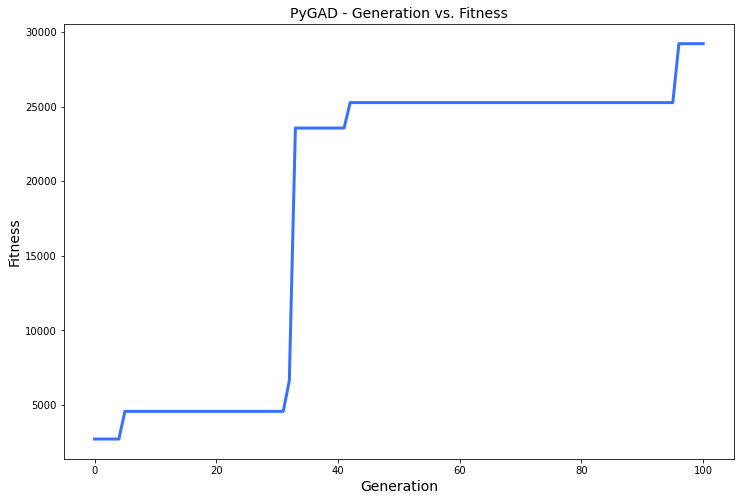

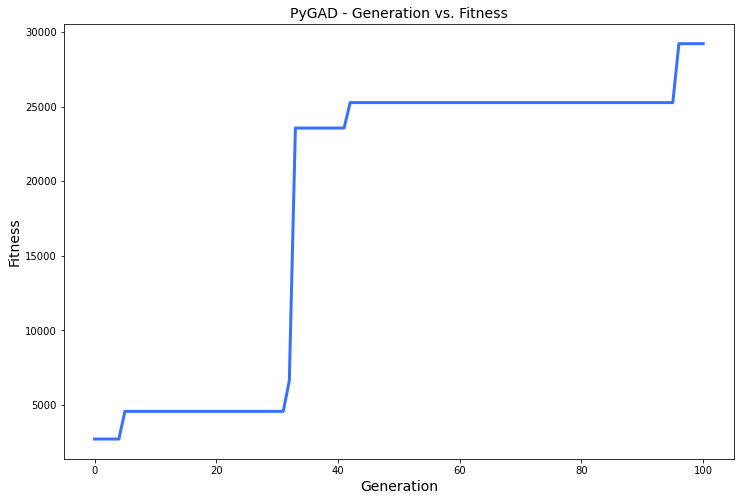

In [116]:
ga_instance.plot_result()

In [117]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 26.459 |===========| 12.301
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |===========| 7.557
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 26.541 |===========| 899.697
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |===========| 13.115
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |===========| 36.206
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 26.609 |===========| 14.478
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.118 |===========| 26.442 |===========| 10.125
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.49

In [119]:
# Check the model's prediction
prediction = numpy.sum(numpy.array(config.FUNCTION_INPUTS)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))


Predicted output based on the best solution :0.24989435875130772
Best fitness value reached after 96 generations.


In [122]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(config.INP_FILE_PATH)
results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N6 = pressure.loc[:,'N6']
print(presssure_at_N6)

0    26.540391
Name: N6, dtype: float64


In [131]:
# check if folder exists
if not os.path.exists('Results'):
    os.makedirs('Results')

In [154]:
# Merge all our solutions per generation
solution_per_generation = glob.glob(f"{config.TEMP_DIR}GENERATION_*")

In [160]:
water_model = WaterLeakModel(node='N6')
water_model.export_results(solutions = solution_per_generation, path='results', name='optimization-result-per-generation')
result_generation = pd.read_csv('results/optimization-result-per-generation.csv')
result_generation

File Exported Successfully to path: results/optimization-result-per-generation.csv


,GENERATION,FITNESS
0,13.0,4558.616882
1,12.0,4558.616882
2,38.0,23562.039984
3,10.0,4558.616882
4,9.0,4558.616882
...,...,...
95,37.0,23562.039984
96,6.0,4558.616882
97,7.0,4558.616882
98,36.0,23562.039984


In [162]:
fitness_solution_per_population = glob.glob(f"{config.TEMP_DIR}FITNESS_SOLUTION_*")
water_model.export_results(solutions = fitness_solution_per_population, path='results', name='optimization-result-per-fitness')
fitness_solution_per_population = pd.read_csv('results/optimization-result-per-fitness.csv')
fitness_solution_per_population

File Exported Successfully to path: results/optimization-result-per-fitness.csv


,EMITTER_COEFFIENT_SOLUTION,OUTPUT,OUTPUT_DEMAND,FITNESS,EMITTER_COEFFICIENT_SOLUTION
0,NaN,26.513518,10.1,37.256983,0.669943
1,NaN,26.519867,10.1,48.800836,0.629876
2,NaN,26.400768,10.1,7.163791,1.368350
3,NaN,26.547193,10.1,146.271879,0.456477
4,NaN,26.578822,10.1,25.997008,0.253777
...,...,...,...,...,...
1915,NaN,26.572589,10.1,31.024838,0.293900
1916,NaN,26.462804,10.1,12.894229,0.987077
1917,NaN,26.570671,10.1,32.987477,0.306225
1918,NaN,26.411858,10.1,7.782047,1.300709


In [168]:
final_data = pd.merge(fitness_solution_per_population,result_generation, how='right')
final_data

,EMITTER_COEFFIENT_SOLUTION,OUTPUT,OUTPUT_DEMAND,FITNESS,EMITTER_COEFFICIENT_SOLUTION,GENERATION
0,NaN,26.540139,10.1,4558.616882,0.501388,13.0
1,NaN,26.540139,10.1,4558.616882,0.501388,12.0
2,NaN,26.540399,10.1,23562.039984,0.499736,38.0
3,NaN,26.540139,10.1,4558.616882,0.501388,10.0
4,NaN,26.540139,10.1,4558.616882,0.501388,9.0
...,...,...,...,...,...,...
95,NaN,26.540399,10.1,23562.039984,0.499736,37.0
96,NaN,26.540139,10.1,4558.616882,0.501388,6.0
97,NaN,26.540139,10.1,4558.616882,0.501388,7.0
98,NaN,26.540399,10.1,23562.039984,0.499736,36.0


In [175]:
final_data.describe()

,OUTPUT,OUTPUT_DEMAND,FITNESS,EMITTER_COEFFICIENT_SOLUTION,GENERATION
count,47.000000,4.700000e+01,100.000000,47.000000,100.000000
mean,26.540271,1.010000e+01,18632.389681,0.500550,50.500000
std,0.000182,8.977806e-15,9881.223542,0.001158,29.011492
min,26.540139,1.010000e+01,2701.900476,0.497652,1.000000
25%,26.540139,1.010000e+01,4558.616882,0.499736,25.750000
50%,26.540139,1.010000e+01,25269.963706,0.501388,50.500000
75%,26.540399,1.010000e+01,25269.963706,0.501388,75.250000
max,26.540727,1.010000e+01,29221.752649,0.501388,100.000000


In [179]:
final_data.isna().sum()

OUTPUT                          53
OUTPUT_DEMAND                   53
FITNESS                          0
EMITTER_COEFFICIENT_SOLUTION    53
GENERATION                       0
dtype: int64

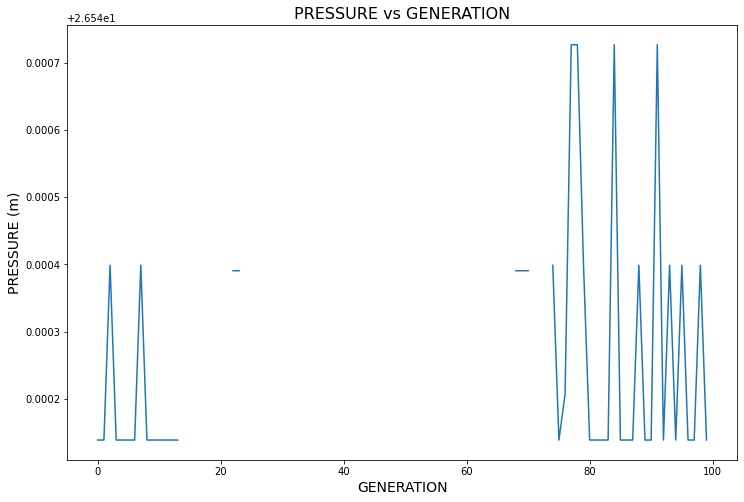

In [180]:
xx=list(range(0,len(final_data)))
plt.plot(xx,list(final_data['OUTPUT']))
plt.xlabel('GENERATION',fontsize=14) ### population
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE vs GENERATION',fontsize=16)
# plt.xticks(xx,list(pressure.columns))
plt.show();
plt.savefig(f"{config.PLOTS_DIR}/PRESSURE_VS_GENERATION.png")
plt.close()

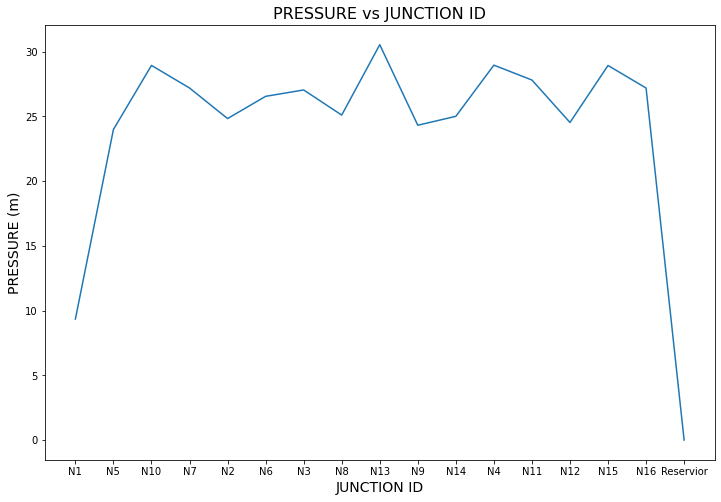

In [185]:
#### pressure vs junction ######
xx=list(range(1,len(list(pressure.columns))+1))
plt.plot(xx,list(pressure.values[0,:]))
plt.xlabel('JUNCTION ID',fontsize=14) ### population
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE vs JUNCTION ID',fontsize=16)
plt.xticks(xx,list(pressure.columns))
plt.show();
plt.savefig(f"{config.PLOTS_DIR}/HEAD_VS_JUNCTION.png")
plt.close()

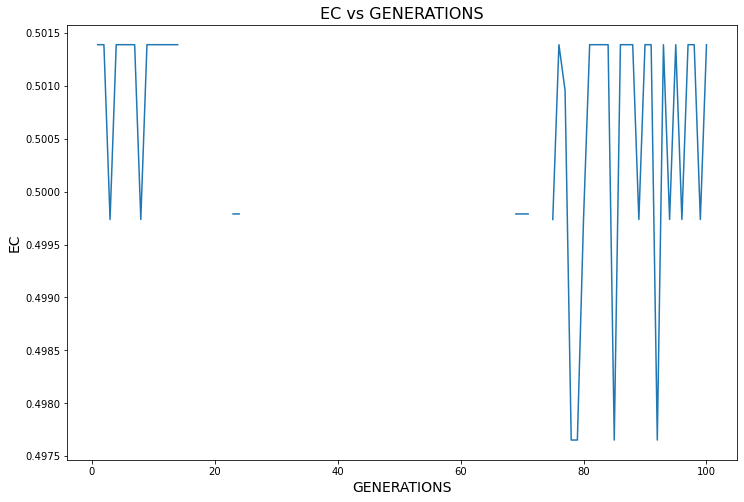

In [186]:
######## fitness vs generations #######
xx=list(range(1,len(final_data)+1))
plt.plot(xx,final_data['EMITTER_COEFFICIENT_SOLUTION'])
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('EC',fontsize=14)
plt.title('EC vs GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{config.PLOTS_DIR}/EC_VS_GEN.png")
plt.close()

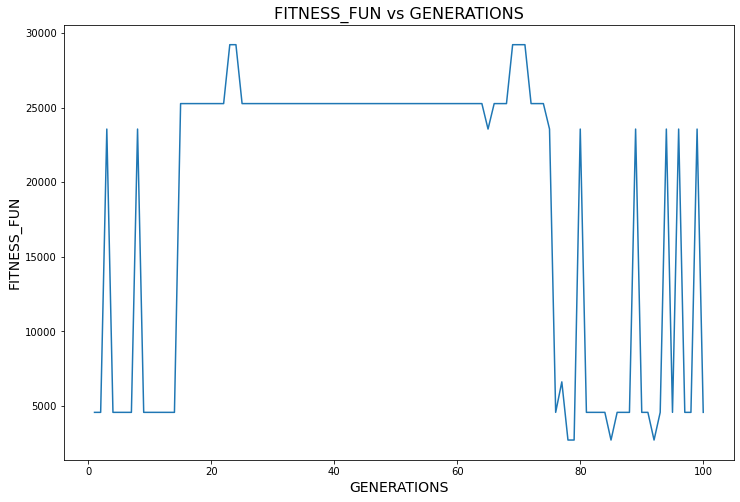

In [187]:
xx=list(range(1,len(final_data)+1))
plt.plot(xx,final_data['FITNESS'])
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('FITNESS_FUN',fontsize=14)
plt.title('FITNESS_FUN vs GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{config.PLOTS_DIR}/FITNESS_FUN_VS_GEN.png")
plt.close()

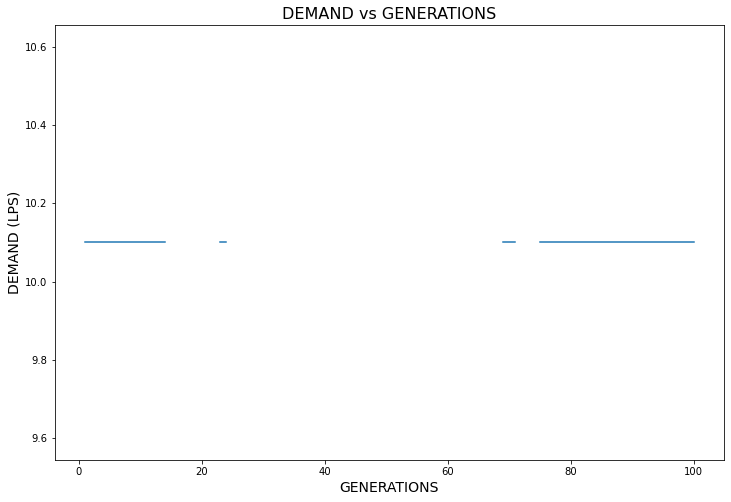

In [188]:
xx=list(range(1,len(final_data)+1))
plt.plot(xx,final_data['OUTPUT_DEMAND'])
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('DEMAND (LPS)',fontsize=14)
plt.title('DEMAND vs GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{config.PLOTS_DIR}/DEMAND_VS_GEN.png")
plt.close()